In [1]:
import BayesianOptimisation.expGrid as expGrid
import BayesianOptimisation.expVoronoi as expVoronoi
import BayesianOptimisation.bo2VoronoiDirected as bo2VoronoiDirected
import BayesianOptimisation.experiment_setup as experiment
from core.DataStructure import *

from importlib import reload
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import copy
import time
import os
import itertools

from scipy.optimize import minimize, Bounds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Reshape
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

# Constant
np.random.seed(9)
NUM_SAMPLE = 50

COLOUR = itertools.cycle(['#00FFFF', '#6495ED', '#89CFF0', '#0000FF', '#7393B3', '#088F8F', 
                          '#0096FF', '#0047AB', '#00FFFF', '#00008B', '#6F8FAF',
                          '#1434A4', '#7DF9FF', '#6082B6', '#00A36C', '#5D3FD3',
                          '#ADD8E6'])

In [2]:
# Updated Get Coverage, take into account of obs now
def getCoverage(exp, G, directed = False, save_fig_path = None):
    total_area = 0
    total_dist = 0
    assigned = {}
    fig, ax = plt.subplots(figsize=(6,6))
    plt.xlim(0,exp.image.shape[1])
    plt.ylim(0,exp.image.shape[0])
    count = 0
    
    for o in exp.obstacles_loc:
        adjustedx, adjustedy = o[1],o[0]
        rect = Rectangle((adjustedx-0.5,adjustedy-0.5),1,1,linewidth=0.1,fill=True, angle = 0, color = 'black')
        plt.gca().add_patch(rect)
    im = fig
    im.canvas.draw()
    X = np.array(im.canvas.renderer._renderer)
    X_reshape = X.reshape((-1,4))
    X_reshape = np.delete(X_reshape, [1,2,3], axis = 1)
    obs_black = np.count_nonzero(X_reshape == 0)
    print("Obstacle Black", obs_black)
    
    for n in G.nodes:
        for e in G.neighbors(n):
            if n != e and frozenset((n, e)) not in assigned.keys():
                
                p1 = G.nodes[n]['position']
                p2 = G.nodes[e]['position']
                
                if (directed):
                    d = G.edges[n,e,0]['distance']
                    c = G.edges[n,e,0]['capacity']*exp.ROBOT_RADIUS
                else:
                    d = G.edges[n,e]['distance']
                    c = G.edges[n,e]['capacity']*exp.ROBOT_RADIUS
                
                
                assigned[frozenset((n, e))] = 1

                adjustp1 = Point(p1.y, p1.x)
                adjustp2 = Point(p2.y, p2.x)

                refpt1 = adjustp1 if adjustp1.y <= adjustp2.y else adjustp2
                refpt2 = adjustp1 if adjustp1.y > adjustp2.y else adjustp2

                if refpt1.x >= refpt2.x:
                    theta_rot = np.pi - np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))
                else:
                    theta_rot = np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))

                if theta_rot >= np.pi/2:
                    theta = theta_rot - np.pi/2
                else:
                    theta = theta_rot + np.pi/2

                dy = -(c/2)*np.sin(theta)
                if refpt1.y == refpt2.y:
                    dx = 0
                    width = d
                    height = c
                    a = 0
                elif refpt1.x > refpt2.x:
                    dx = -(c/2)*np.cos(theta)
                    width = c
                    height = d
                    a = (theta) * 180 / np.pi
                elif refpt1.x == refpt2.x:
                    dx = -(c/2)
                    width = c
                    height = d
                    a = 0
                else:
                    dx = (c/2)*np.cos(np.pi - theta)
                    width = d
                    height = c
                    a = (theta_rot) * 180 / np.pi
                    
                print_colour = 'blue' if save_fig_path != None else 'black'
                rect = Rectangle((refpt1.x+dx,refpt1.y+dy),width,height,linewidth=0.1,fill=True, angle = a,color = print_colour )
                plt.gca().add_patch(rect)
                count +=1

    ax.axis('off')
    if save_fig_path != None:
        plt.savefig(save_fig_path)

    im = fig
    im.canvas.draw()
    X = np.array(im.canvas.renderer._renderer)
    X_reshape = X.reshape((-1,4))
    X_reshape = np.delete(X_reshape, [1,2,3], axis = 1)
    black = np.count_nonzero(X_reshape == 0)
    white= np.count_nonzero(X_reshape == 255)
    percentage = (black-obs_black)/(white+black-obs_black)

    return percentage

In [3]:
def showVorSolution(
    paths = None,
    graph = None, 
    exp = None, 
    save_fig_path = None):
    
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-exp.image)
    ax = sb.heatmap(img)
    colors = copy.deepcopy(COLOUR)
    
    for agent, path in enumerate(paths):
        colour = next(colors)
        for t, n in enumerate(path):
            if t == 0:
                continue
            past_n = path[t-1]
            
            p2 = graph.nodes[n]['position']
            p1 = graph.nodes[past_n]['position']
            
            plt.plot([p1.y,p2.y], [p1.x, p2.x], alpha=0.9, color = colour, linewidth=2)
        if np.all(graph.nodes[n]['position'] == exp.end_locations[agent]):
            break

    for p in exp.start_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='none', edgecolors='r')
    for p in exp.end_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='r', edgecolors='r')

    
    plt.gca().invert_yaxis()
#     plt.savefig(save_fig_path)
    return fig

In [4]:
DATASET = 1
OBJECTIVE = 'Both'
NUM_AGENT = 2

In [5]:
scenemap = "./input/random-32-32-10/random-32-32-10.map"
scene = "./input/random-32-32-10/scen-even/random-32-32-10-even-" + str(DATASET) + ".scen"
exp = experiment.Experiment(scenemap=scenemap, scene=scene, objective= OBJECTIVE, num_agent=NUM_AGENT)
exp.setParameters()

Set Hyper Parameters, solving for 2 agents


In [ ]:
scenemap = "./input/same_density/den101d/den101d.map"
scene = "./input/same_density/den101d/den101d.scen"
exp2 = experiment.Experiment(scenemap=scenemap, scene=scene, objective= OBJECTIVE, num_agent=NUM_AGENT)
exp2.setParameters()

In [ ]:
 # Voronoi
vor_paths,vor_cost,vor_penality,vor_ft, vor_u1, vor_u2, vor_con, vor_conmax, vor_conavg, vor_G = expVoronoi.exp_voronoi(exp2)
assert exp2.NUM_OF_AGENT == NUM_AGENT # raise error if cant find that many agent

In [ ]:
vor_u2 = getCoverage(exp2,vor_G)

In [ ]:
# _ = showVorSolution(
#     paths=vor_paths, 
#     graph=vor_G,
#     exp=exp2)

In [5]:
def count_obs_density(scene_map="./input/random-32-32-10/random-32-32-10.map"):
    f = open(scene_map, "r")
    lines = f.readlines()
    f.close()
    
    height = int(lines[1].split()[1])
    width = int(lines[2].split()[1])
    
    obstacles = []
    boundary = 0
    obs = 0
    free_space = 0
    for index in range (4, 4+height):
        cur_line = bytes(lines[index],'utf-8')
        k = np.array(list(cur_line), dtype = np.unicode)
        k = k[:width]

        a = np.array(np.where(k == '64'))
        b = np.array(np.where(k == '84'))
        c = np.array(np.where(k == '46'))
        
        boundary += a.shape[1]
        obs += b.shape[1]
        free_space += c.shape[1]
        
#     print(boundary, obs, free_space)
    print("Require", (obs+free_space)*0.45-obs)
        
    if scene_map == "./input/random-32-32-10/random-32-32-10.map":
        return boundary/(boundary+free_space)
        
    return obs/(obs+free_space)
                                    

In [7]:
# scenemap = "./input/random-32-32-10/random-32-32-10.map"
# density1 = count_obs_density(scene_map = scenemap)

# scenemap2 = "./input/same_density/den101d/den101d.map"
scenemap2 = "./input/probable/den101d.map"
# scene2 = "./input/same_density/den101d/den101d.scen"
density2 = count_obs_density(scene_map = scenemap2)

# scenemap3 = "./input/same_density/lak109d/lak109d.map"
scenemap3 = "./input/probable/lak109d.map"
# scene3 = "./input/same_density/lak109d/lak109d.scen"
density3 = count_obs_density(scene_map = scenemap3)

# scenemap4 = "./input/same_density/lak105d/lak105d.map"
scenemap4 = "./input/probable/lak105d.map"
# scene4 = "./input/same_density/lak105d/lak105d.scen"
density4 = count_obs_density(scene_map = scenemap4)
density4

Require 22.950000000000045
Require -109.44999999999999
Require 48.10000000000002


0.383008356545961

In [21]:
density2

0.4405594405594406

In [22]:
density3

0.5942028985507246

In [23]:
density4

0.4510050251256281

In [21]:
scenemap = "./input/probable/lak105d.map"
scene = "./input/same_density/lak105d/lak105d.scen"
exp2 = experiment.Experiment(scenemap=scenemap, scene=scene, objective= OBJECTIVE, num_agent=17)
exp2.setParameters()

cant find enough start end pair
Set Hyper Parameters, solving for 0 agents


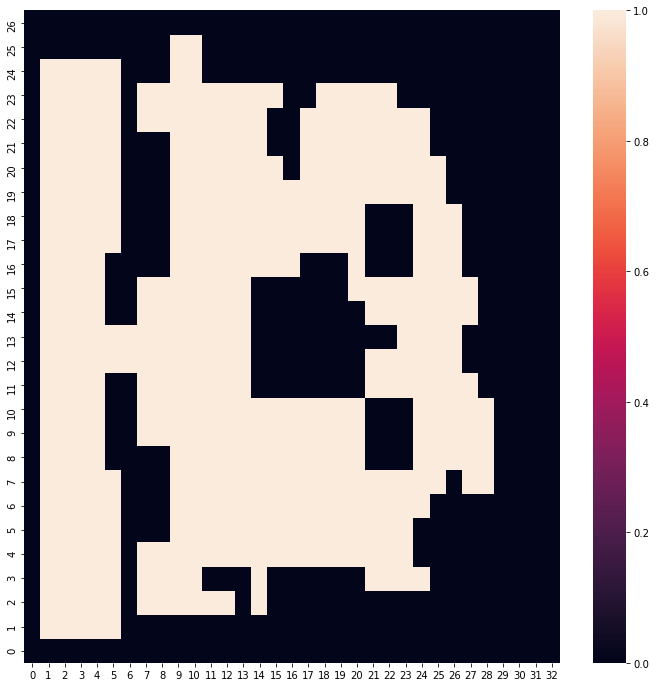

In [22]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sb.heatmap(1-exp2.image)
plt.gca().invert_yaxis()

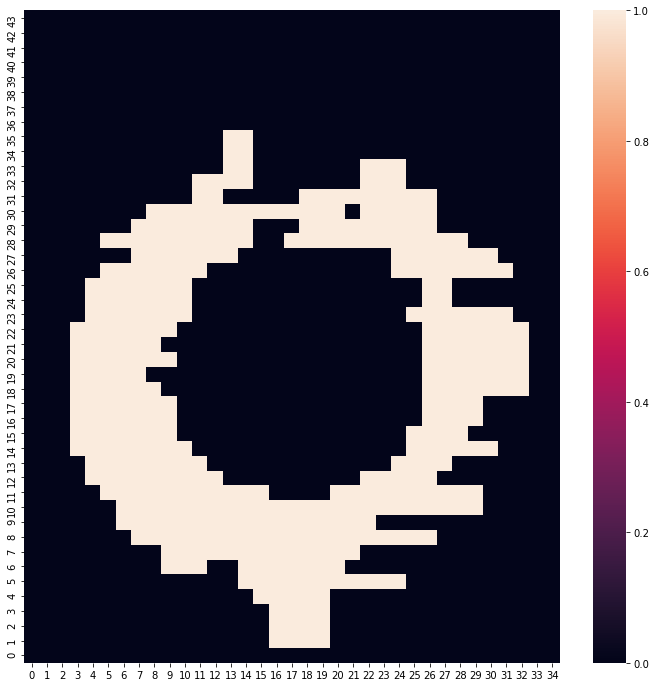

In [41]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sb.heatmap(1-exp2.image)
plt.gca().invert_yaxis()

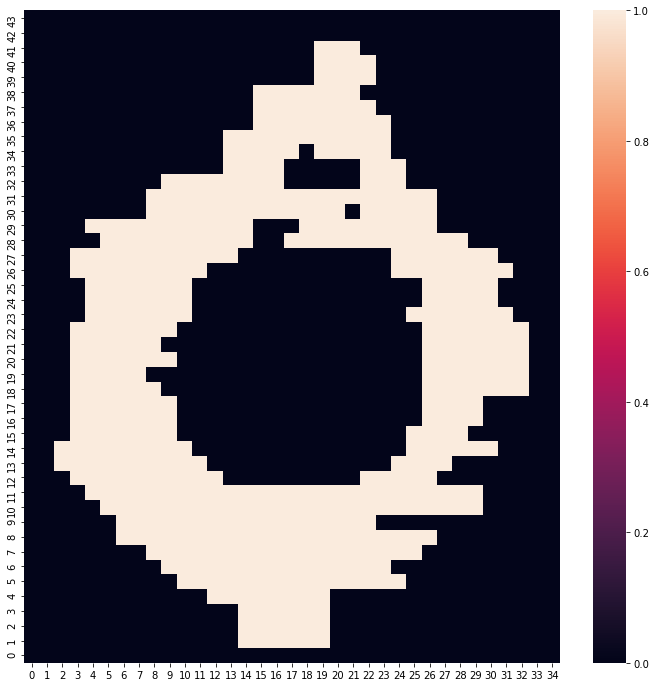

In [39]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sb.heatmap(1-exp2.image)
plt.gca().invert_yaxis()

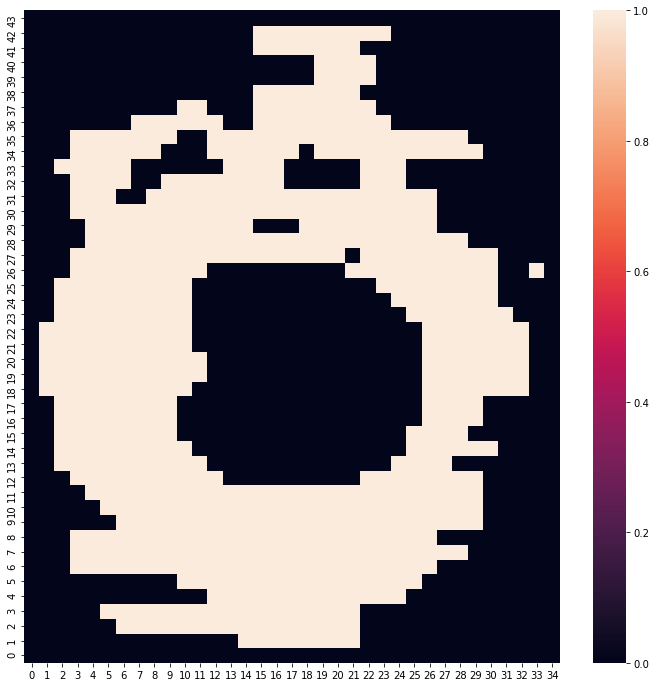

In [36]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sb.heatmap(1-exp2.image)
plt.gca().invert_yaxis()